<a href="https://colab.research.google.com/github/pinnouse/zeroshot-unsurpervised-mt/blob/main/CSC413_FP_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train Loop

PyTorch training for GAN:
[PyTorch blog](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [ ]:
print(tokenizer.vocab_size)
real_decoder = Decoder(tokenizer.vocab_size)
transformer = Transformer(tokenizer.vocab_size) # temp vocab size
translate = Translator(hidden=512)
discriminator = Discriminator()

real_decoder.to(device)
transformer.to(device)
translate.to(device)
discriminator.to(device)

119547


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=512, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

("L’algèbre linéaire est la branche des mathématiques qui s'intéresse aux espaces vectoriels et aux transformations linéaires, formalisation générale des théories des systèmes d'équations linéaires", tensor([  101,   149,   100, 10164, 10240, 13340, 13724, 11614, 11246, 16556,
        10176, 10109, 58760, 10139, 71777, 10355,   187,   112, 26391, 20017,
        12818, 10754, 84355, 46514, 19428, 10107, 10131, 10754, 44510, 10107,
        11614, 11246, 29194,   117, 23129, 20312, 28274, 10139, 38914, 10107,
        10139, 48273,   172,   112,   263, 32973, 15024, 11614, 11246, 29194,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], device='cuda:0'))
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch 1:


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


	train loss (decoder)   : 0.11261320114135742
	train loss (generator) : 0.045172639191150665
	train loss (discrim)   : 0.0029248371720314026
	train loss (translator): 0.0003937671717721969
	took: 0.643282 seconds
Epoch 2:
	train loss (decoder)   : 0.11436402052640915
	train loss (generator) : 0.09641090035438538
	train loss (discrim)   : 0.0026256199926137924
	train loss (translator): 0.0003472926910035312
	took: 0.696091 seconds
Epoch 3:
	train loss (decoder)   : 0.11275860667228699
	train loss (generator) : 0.11707045882940292
	train loss (discrim)   : 0.0024344888515770435
	train loss (translator): 0.0003747942391782999
	took: 0.592342 seconds
Epoch 4:
	train loss (decoder)   : 0.10536080598831177
	train loss (generator) : 0.13133063912391663
	train loss (discrim)   : 0.0021367736626416445
	train loss (translator): 0.0002957336837425828
	took: 0.622852 seconds
Epoch 5:
	train loss (decoder)   : 0.13265210390090942
	train loss (generator) : 0.09399819374084473
	train loss (discrim)  

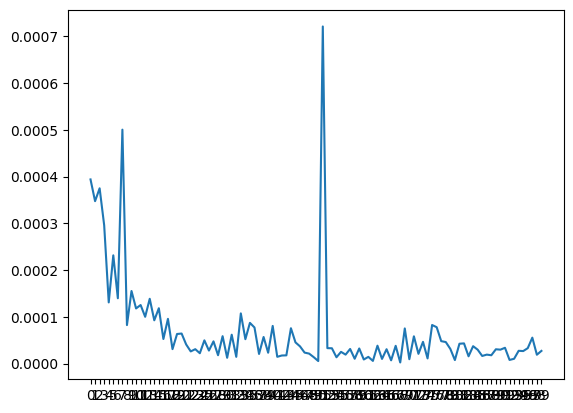

In [ ]:
from torch import optim
# https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.Adafactor
from transformers.optimization import Adafactor
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive

context_length = 64

# TODO: add device specific code

def pad(tokens, context_length):
  l = list(tokens)
  for _ in range(context_length - len(tokens)):
    l.append(tokenizer.pad_token_id)
  return np.array(l)

def train(real_decoder, transformer, discriminator, translate, # our four models
          real_train, other_train, real_valid = None, other_valid = None, device = 'cpu',
          epochs = 10, batch_size = 256, ckpt_path = None, ckpt_interval = 10):
  batch_data = []

  # yash
  data_loader = [(real_train, other_train)]

  criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
  criterion_binary = nn.BCEWithLogitsLoss()
  mse = nn.MSELoss()

  # r_optim = optim.RAdam(real_decoder.parameters())
  # g_optim = optim.RAdam(generator.parameters())
  r_optim = Adafactor(real_decoder.parameters())
  g_optim = Adafactor(transformer.parameters())
  t_optim = Adafactor(translate.parameters())
  d_optim = Adafactor(discriminator.parameters())

  r_iterations = len(real_train) // batch_size
  o_iterations = len(other_train) // batch_size
  # r_iterations = real_train.shape[0] // batch_size
  # o_iterations = other_train.shape[0] // batch_size

  n = min(r_iterations, o_iterations)

  losses = []

  for e in range(epochs):
    r_epoch_loss = 0
    g_epoch_loss = 0
    d_epoch_loss = 0
    t_epoch_loss = 0
    # yash (every epoch: shuffle)
    # data_loader = batcherize(train_data)
    # data_loader.shuffle()
    # random.shuffle(batches of the dataloader)
    epoch_start = datetime.now()
    print(f'Epoch {e+1}:')
    for i, (r_x, o_x) in enumerate(data_loader):
      # r_x: (english sentence: str, CLIP embeddings: float[512], tokens: one-hots[num tokens])[batch_size]
      # o_x: (fr sentence: str, tokens: one-hot[num tokens])[batch_size]
      # if r_x.shape[0] < batch_size: # not full batch
      #   break
      if (i + 1) % 100 == 0:
        print(f'Iteration {i+1} of {n}')

      n_r = len(r_x)
      n_o = len(o_x)

      rx_clips = torch.tensor(np.array(list(map(lambda x: x[1], r_x))), device=device)
      rx_toks = torch.tensor(np.array(list(map(lambda x: x[2].numpy(force=True), r_x))), device=device)
      ox_toks = torch.tensor(np.array(list(map(lambda x: x[1].numpy(force=True), o_x))), device=device)

      # ==============================
      # == learn decoder
      # ==============================
      tgt_in = rx_toks[:, :-1]
      tgt_expect = rx_toks[:, 1:]
      r_mask = nn.Transformer.generate_square_subsequent_mask(context_length - 1, device=device)
      r_output = real_decoder(rx_clips, tgt_in, tgt_mask=r_mask)
      r_output = r_output.permute(0,2,1)
      r_loss = criterion(r_output, tgt_expect)
      r_epoch_loss += r_loss.item()

      r_optim.zero_grad()
      r_loss.backward(retain_graph=True)
      r_optim.step()

      # ==============================
      # == self learn monolingual
      # ==============================
      # "other" generator self supervised
      # https://jamesmccaffrey.wordpress.com/2022/09/09/simplest-transformer-seq-to-seq-example/
      
      src = ox_toks
      tgt = src
      tgt_in = tgt[:,:-1]
      tgt_expect = tgt[:,1:]
      t_mask = nn.Transformer.generate_square_subsequent_mask(context_length - 1, device=device)
      # https://pytorch.org/tutorials/beginner/translation_transformer.html#seq2seq-network-using-transformer
      tgt_attn_mask = (tgt_in == tokenizer.pad_token_id)
      attn_mask = (src == tokenizer.pad_token_id)

      output, other_embeddings = transformer(src, tgt_in, tgt_mask=t_mask, tp_mask=tgt_attn_mask, sp_mask=attn_mask) # [bs,seq,vocab]

      # get preds shape to conform to tgt_expect
      output = output.permute(0,2,1)  # now [bs, vocab, seq]

      g_loss = criterion(output, tgt_expect)
      g_epoch_loss += g_loss.item()

      g_optim.zero_grad()
      g_loss.backward(retain_graph=True)
      g_optim.step()

      # ==============================
      # == learn discriminator
      # ==============================
      fake_embs, F_embs = translate(other_embeddings[:,-1,:])
      real_embs = rx_clips[:,-1,:]
      inputs = torch.cat([real_embs, fake_embs])
      reals = torch.ones(n_r, device=device) #whatever batch_sizes will be
      fakes = torch.zeros(n_o, device=device) # ^^
      labels = torch.cat([reals,fakes]) #[n_1 + n_2,512]

      d_outputs = discriminator(inputs) 
      d_loss = criterion_binary(d_outputs, labels)
      d_epoch_loss += d_loss.item()
      d_optim.zero_grad()
      d_loss.backward(retain_graph=True)
      d_optim.step()

      # ==============================
      # == learn translator
      # ==============================
      
      t_outputs = discriminator(fake_embs)
      t_loss = criterion_binary(t_outputs, fakes)
      tl_loss = mse(F_embs, other_embeddings[:,-1,:]) # "cycle GAN" reconstruct fr embeddings
      t_epoch_loss += t_loss.item()
      t_optim.zero_grad()
      t_loss.backward(retain_graph=True)
      tl_loss.backward()
      t_optim.step()


    print(f'\ttrain loss (decoder)   : {r_epoch_loss}')
    print(f'\ttrain loss (generator) : {g_epoch_loss}')
    print(f'\ttrain loss (discrim)   : {d_epoch_loss}')
    print(f'\ttrain loss (translator): {t_epoch_loss}')
    print(f'\ttook: {(datetime.now() - epoch_start).total_seconds()} seconds')
    losses.append(t_epoch_loss)
    if ckpt_path is not None and e % ckpt_interval == 0:
      state = {
          'real_decoder_state': real_decoder.state_dict(),
          'real_decoder_loss': r_epoch_loss,
          'transformer_state': transformer.state_dict(),
          'transformer_loss': t_epoch_loss,
          'discriminator_state': discriminator.state_dict(),
          'discriminator_loss': d_epoch_loss,
          'translate_state': translate.state_dict(),
          'translate_loss': t_epoch_loss,
      }
      torch.save(state, ckpt_path + f'/ckpt-epoch-{e}.pt')
  # plt.xticks(np.arange(epochs))
  plt.plot(losses)
  plt.show()

print(train_data_fr[0])
# To disable checkpointing, comment the next two lines and remove the ckpt_path
# parameter in the call to train().
drive.mount('/content/gdrive')
ckpt_path = '/content/gdrive/My Drive/CSC413/Project/'
train(real_decoder, transformer, discriminator, translate, [train_data_en[0]] * 2, [train_data_fr[0]] * 16, epochs=100, device=device, ckpt_path=ckpt_path)
# train(real_decoder, transformer, discriminator, translate, train_data_en, train_data_fr, epochs=100, ckpt_path=ckpt_path)

### Overfit Inference

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
ckpt_path = '/content/gdrive/My Drive/CSC413/Project/ckpt-epoch-90.pt'
checkpoint = torch.load(ckpt_path)

real_decoder.load_state_dict(checkpoint['real_decoder_state'])
transformer.load_state_dict(checkpoint['transformer_state'])
translate.load_state_dict(checkpoint['translate_state'])
# discriminator.load_state_dict(checkpoint['discriminator'])

real_decoder.eval()
transformer.eval()
translate.eval()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Translator(
  (G): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (F): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [ ]:
x = train_data_fr[0]
print(f'input: {x}')
xx = torch.tensor(np.array([x[1].numpy()]))
sp = (xx == tokenizer.pad_token_id)
embs = transformer.encode(xx, sp_mask=sp)
en_embs, _ = translate(embs[:,-1:])

print('='*26)
s = [tokenizer.cls_token_id]
for i in range(30):
  seq = torch.tensor(np.array([s]))
  t_mask = nn.Transformer.generate_square_subsequent_mask(i + 1)
  o = real_decoder(en_embs[:,-1:], seq, t_mask)
  m = torch.argmax(o, dim=2)
  tk = m[0, -1]
  s.append(tk)
  print(tokenizer.decode(s))
  if tk == tokenizer.eos_token_id:
    break

input: ('Arsène Lupin est un personnage de fiction français créé par Maurice Leblanc', tensor([  101, 64304, 18105, 23859, 17298, 10176, 10119, 28601, 10104, 20455,
        12501, 23673, 10248, 15560, 10281, 22491, 29420,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]))
[CLS] April
[CLS] April is
[CLS] April is the
[CLS] April is the fourth
[CLS] April is the fourth month
[CLS] April is the fourth month of
[CLS] April is the fourth month of the
[CLS] April is the fourth month of the year
[CLS] April is the fourth month of the year in
[CLS] April is the fourth month of the year in the
[CLS] April is the fourth month of the year in the Julian
[CLS] April is the fourth mon